# Feature importance

In [1]:
from utils.utils_pixel import *
#from model_shap import *

# import packages
import shap
import numpy as np
from pathlib import Path
import torch as th
from torch.utils.data import DataLoader
import time
from tqdm import tqdm # Instantly make your loops show a smart progress meter
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.functional import r2_score
from torchsummary import summary
from PIL import Image
import uuid
import pandas as pd
from datetime import datetime
import warnings
import argparse
import importlib
warnings.filterwarnings("ignore")

/dccstor/cimf/drought_impact/drought/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data and model

In [14]:
########################################################################
# SET UP PARAMETERS FROM CONFIGURATION FILE

config_id = 'train_config_clean_filter'
module = importlib.import_module(f'utils.{config_id}')
train_dataset_params = module.train_dataset_params
train_sampler_params = module.train_sampler_params
sim_params = module.sim_params
model_params = module.model_params


# ==================================================================================================
# Get setup details from configuration file

feature_set = train_dataset_params['feature_set']
remove_bands = train_dataset_params['remove_bands']
multiple_labels = train_dataset_params['multiple_labels']
batch_size_tr =  train_sampler_params['batch_size'] 
n_batch = 1 #sim_params['n_batches']
ts_len =  train_dataset_params['ts_len']
len_preds =  train_dataset_params['len_preds']

n_train = batch_size_tr*n_batch
batch_size_val = sim_params['batch_size_val'] 
n_batch_val = sim_params['n_batches_val']
batch_size_te = sim_params['batch_size_te'] 
n_batch_te = sim_params['n_batches_te']
exp = sim_params["exp"]
exp_val = sim_params["exp_val"]
exp_te = sim_params["exp_test"]
sample_type = sim_params["sample_type"]
method = sim_params["method"] # direct vs oneshot
cp_idx = sim_params["cp_idx"] # used to mask out clouds in loss (cp_id, ndvi_id)
output_dim = model_params["output_dim"]
n_epochs = 1 #50 #sim_params["num_epochs"]
loss_function = sim_params['loss_function']
optim = sim_params["optimizer"]
n_feats_in = len(feature_set)-len(remove_bands)
n_feats_out = 1
n_timesteps_in = ts_len
n_timesteps_out = len_preds

device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
for epoch in range(n_epochs):
    for batch_nbr in range(n_batch):
        # get the current batch of data
        X_tr = th.zeros([batch_size_tr, n_timesteps_in, len(feature_set)-len(remove_bands)])
        y_tr = th.zeros([batch_size_tr, n_timesteps_out, 1])

        # Load a batch here 
        img, label = load_batch(batch_size=batch_size_tr, batch_nbr=batch_nbr, sample_type=sample_type, split='train', exp=exp, n_timesteps_out=n_timesteps_out)
        # shapes: [batch_size, n_timesteps_in, n_feats_in] and [batch_size, n_timesteps_out, n_feats_out]

        img = remove_features_batch_level(img, remove_bands, feature_set)
        label = remove_features_batch_level(label, remove_bands, feature_set)
        
        # still predict both, but dont use cp_idx for masking clouds in loss
        to_keep = 0
        label = label[:,:,to_keep,:,:]

        X_tr[:, :, :] = th.reshape(img, (batch_size_tr, img.size(dim=1), img.size(dim=2)))#.numpy()
        y_tr[:, :, :] = th.reshape(label, (batch_size_tr, label.size(dim=1), label.size(dim=2)))#.numpy()

        # Concatenate all timesteps after each other
        #X_batch = np.reshape(X_tr, (batch_size, n_timesteps_in*(len(feature_set)-len(remove_band))))
        #y_batch = np.reshape(y_tr, (batch_size, n_timesteps_out*n_feats_out))


In [ ]:
model = LSTM_oneshot(input_dim=n_feats_in, hidden_dim=10, num_layers=1, output_dim=1, batch_size=batch_size_tr, device=device)

## Lasso 

In [2]:
# Load model
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


import mlflow
logged_model = 'runs:/ed6e49e924664ed98421ee29f9388632/model'

# Load model.
loaded_model = mlflow.sklearn.load_model(logged_model)

In [3]:
# Extract the weights of the LSTM layer
lstm_weights = loaded_model.lstm_cell.weight_ih_l0.cpu().detach().numpy()

# Compute the magnitude of each weight for each input feature
weight_magnitudes = np.abs(lstm_weights)

# Compute the average weight magnitude for each input feature
avg_weight_magnitudes = np.mean(weight_magnitudes, axis=0)

In [4]:
# Sort the average weight magnitudes in descending order
ranked_features = np.argsort(avg_weight_magnitudes)[::-1]

# Print the ranked features
print('Ranked features:', ranked_features)

Ranked features: [14 20  2 23 21 19 18 22 28  1 26  3 16 17 30 43 34 32 57 25 56 33 61 27
 31 24 63 45 29 38 68 64 81 78 51 55 47 46 50 54 79 66  8 44 52 74 77 35
 76 49  9 65 80 48  5 40 73 53 67 59 72 69 70  7 75 60 58 62 11 41 12 13
 42 37 71 39 36  4  6 10  0 15]


In [5]:
features = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "NDVI",
               "VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SR" ,"SP", "T", "TCC", "TP", 
               "DEM", 
               "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21",
               "CLAY0_5", "CLAY100_200", "CLAY15_30", "CLAY30_60", "CLAY5_15", "CLAY60_100",
               "FED0_5", "FED100_200", "FED15_30",  "FED30_60", "FED5_15", "FED60_100",
               "FC", "FH",
               "GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]

spectral = ["MSI", "NDMI", "NDVIre", "NDWI", "B11", "B12", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8a", "NDVI"]
climate = ["VPDX", "VPDN", "AWVC", "MAXT", "MINT", "SR" ,"SP", "T", "TCC", "TP"]
topographic = ["DEM", "CURV17", "CURV19", "CURV21", "EAST17", "EAST19", "EAST21", "NORT17", "NORT19", "NORT21", "RUGG17", 
               "RUGG19", "RUGG21", "SLOP17", "SLOP19", "SLOP21", "TWI17", "TWI19", "TWI21"]
vegetation = ["FC", "FH"]
soil = ["GRAV0_5", "GRAV100_200", "GRAV15_30", "GRAV30_60", "GRAV5_15", "GRAV60_100",
               "SAND0_5", "SAND100_200", "SAND15_30", "SAND30_60","SAND5_15",
               "SDEP",
               "CARB0_5", "CARB100_200", "CARB15_30", "CARB30_60", "CARB5_15", "CARB60_100",
               "PH0_5", "PH100_200", "PH15_30", "PH30_60","PH5_15", "PH60_100"]

In [6]:
df_lasso = pd.DataFrame()
df_lasso['feature'] = features
df_lasso['weight'] = avg_weight_magnitudes
df_lasso = df_lasso.sort_values('weight', ascending=False)
df_lasso["Group"] = ["none"]*len(df_lasso)
df_lasso.loc[df_lasso["feature"].isin(spectral), "Group"] = "Spectral"
df_lasso.loc[df_lasso["feature"].isin(climate), "Group"] = "Climate"
df_lasso.loc[df_lasso["feature"].isin(topographic), "Group"] = "Topography"
df_lasso.loc[df_lasso["feature"].isin(vegetation), "Group"] = "Vegetation"
df_lasso.loc[df_lasso["feature"].isin(soil), "Group"] = "Soil"

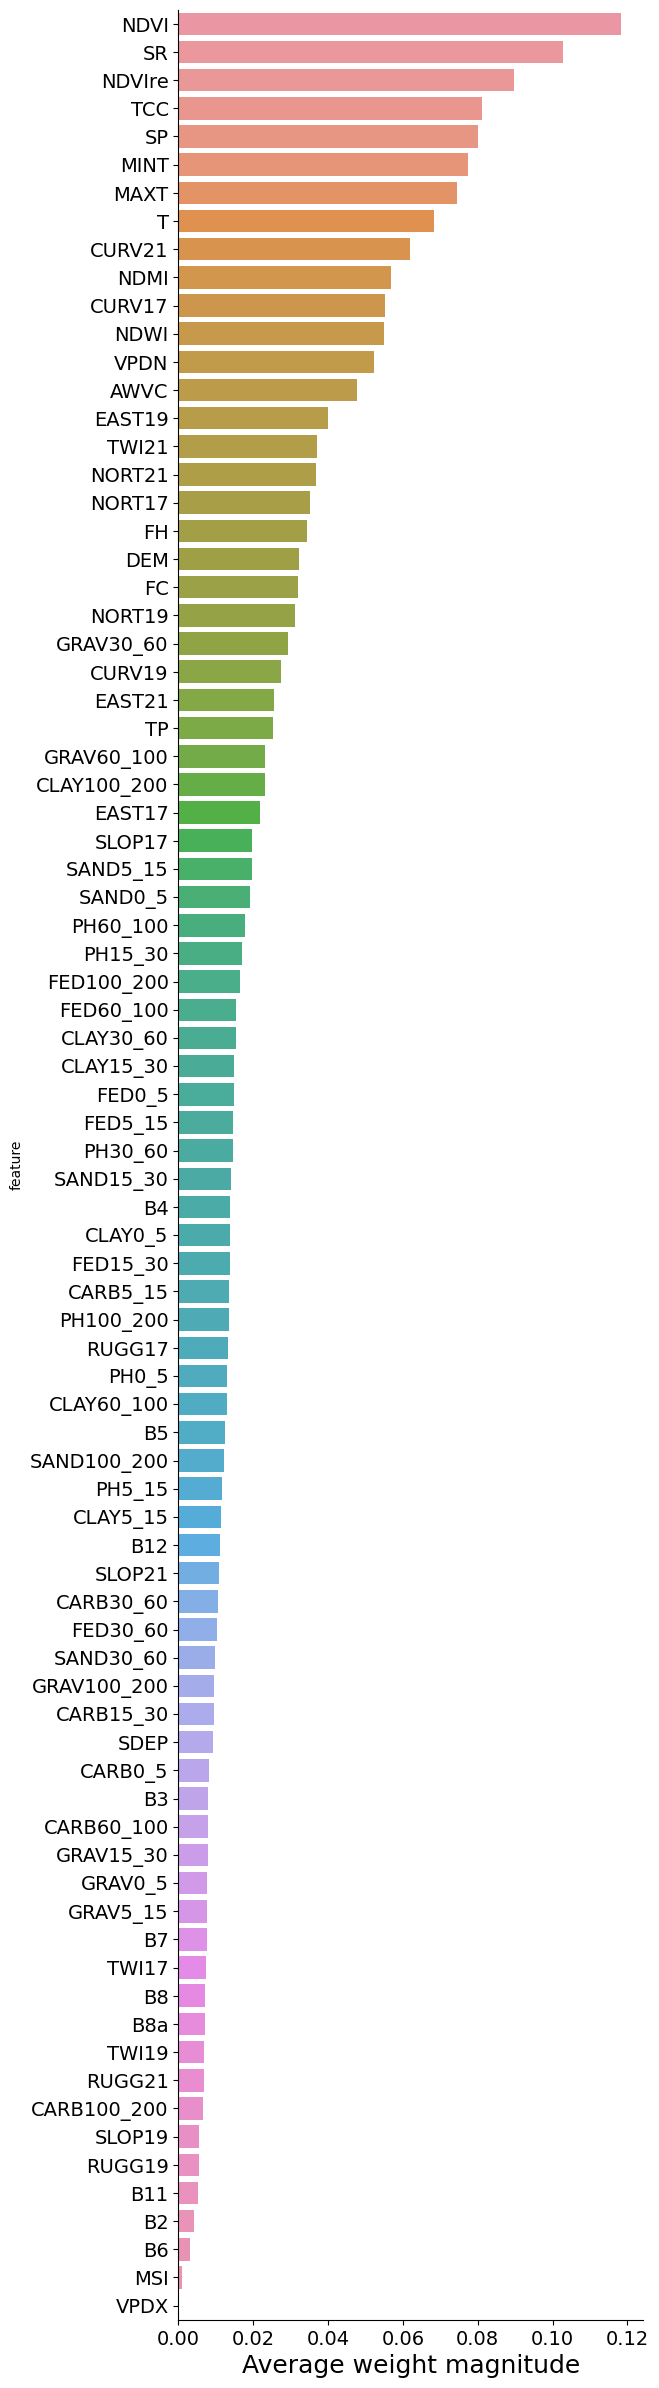

In [61]:
fig, ax = plt.subplots(1,1, figsize=(6,30))
sns.barplot(ax=ax, x='weight', y='feature', data=df_lasso, orient='h')
sns.despine(top=True, right=True)
plt.xlabel('Average weight magnitude', size=18)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)

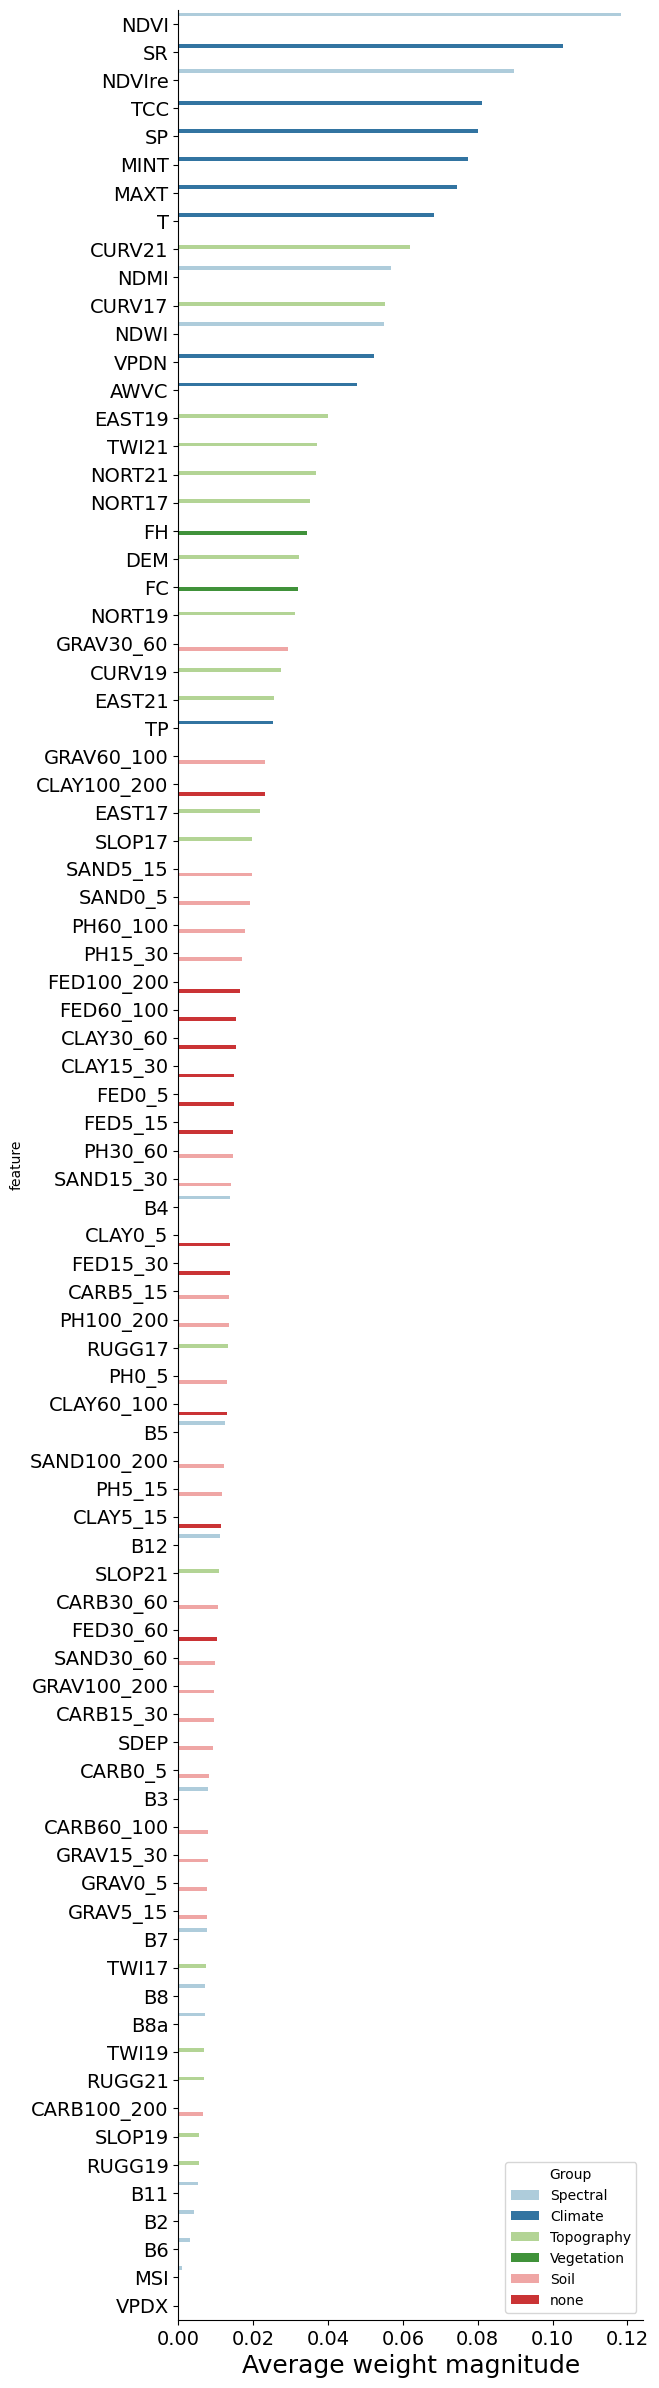

In [56]:
fig, ax = plt.subplots(1,1, figsize=(6,30))
sns.barplot(ax=ax, x='weight', y='feature', data=df_lasso, hue='Group')
sns.despine(top=True, right=True)
plt.xlabel('Average weight magnitude', size=18)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)

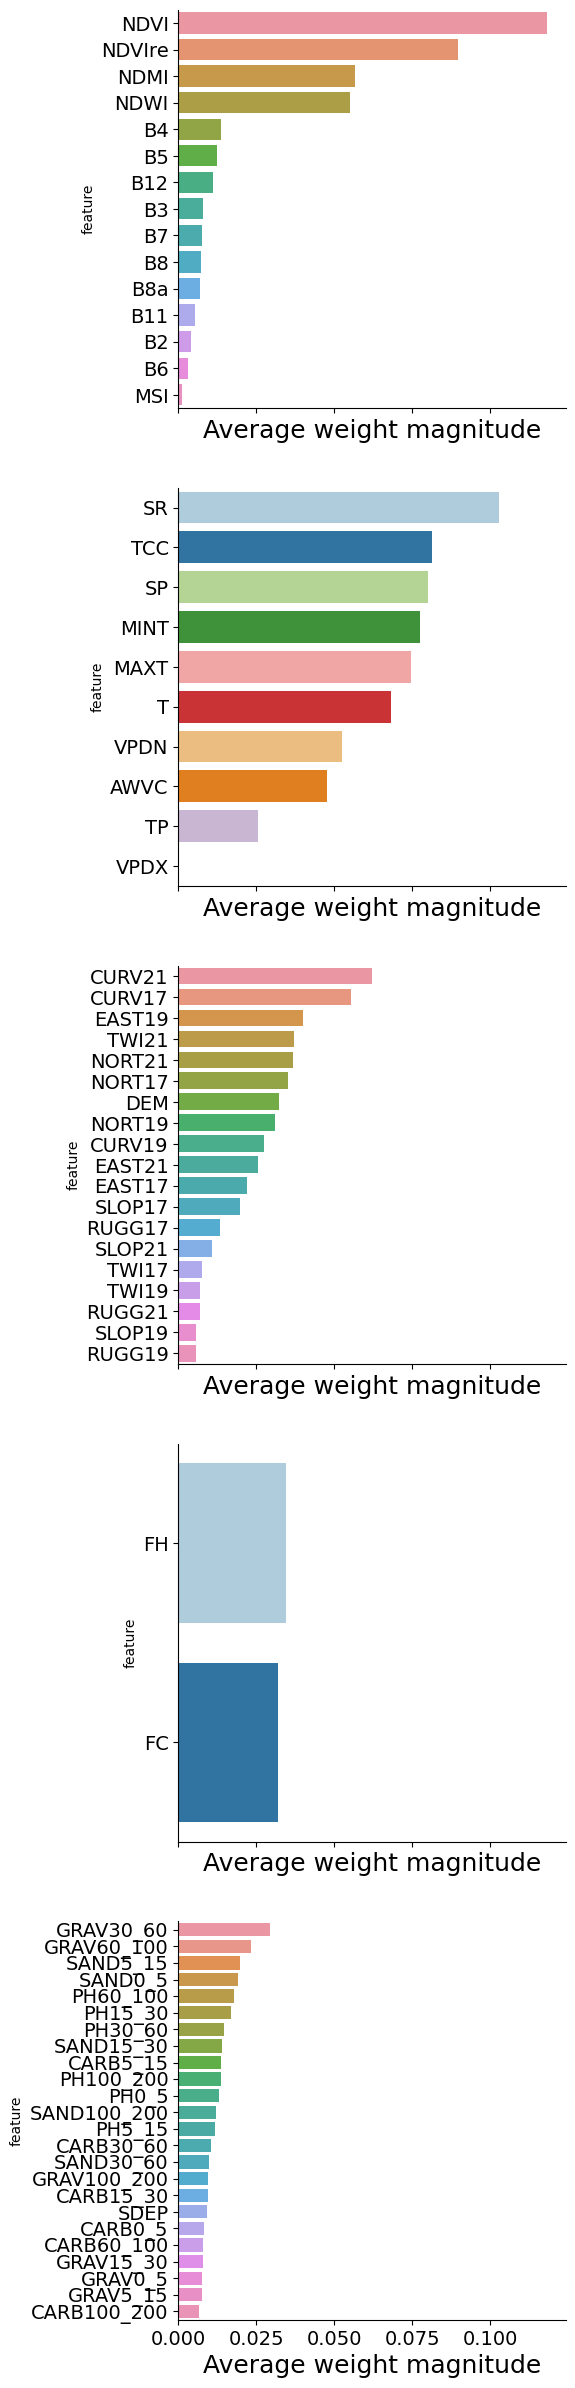

In [63]:
# Plot by group
fig, axs = plt.subplots(5,1, figsize=(5,30), sharex=True)

sns.barplot(ax=axs[0], x='weight', y='feature', data=df_lasso[df_lasso.Group=='Spectral'], orient='h')
sns.despine(top=True, right=True)
axs[0].set_xlabel('Average weight magnitude', size=18)
# We change the fontsize of minor ticks label 
axs[0].tick_params(axis='both', which='major', labelsize=14)

sns.barplot(ax=axs[1], x='weight', y='feature', data=df_lasso[df_lasso.Group=='Climate'], orient='h')
sns.despine(top=True, right=True)
axs[1].set_xlabel('Average weight magnitude', size=18)
# We change the fontsize of minor ticks label 
axs[1].tick_params(axis='both', which='major', labelsize=14)

sns.barplot(ax=axs[2], x='weight', y='feature', data=df_lasso[df_lasso.Group=='Topography'], orient='h')
sns.despine(top=True, right=True)
axs[2].set_xlabel('Average weight magnitude', size=18)
# We change the fontsize of minor ticks label 
axs[2].tick_params(axis='both', which='major', labelsize=14)

sns.barplot(ax=axs[3], x='weight', y='feature', data=df_lasso[df_lasso.Group=='Vegetation'], orient='h')
sns.despine(top=True, right=True)
axs[3].set_xlabel('Average weight magnitude', size=18)
# We change the fontsize of minor ticks label 
axs[3].tick_params(axis='both', which='major', labelsize=14)

sns.barplot(ax=axs[4], x='weight', y='feature', data=df_lasso[df_lasso.Group=='Soil'], orient='h')
sns.despine(top=True, right=True)
axs[4].set_xlabel('Average weight magnitude', size=18)
# We change the fontsize of minor ticks label 
axs[4].tick_params(axis='both', which='major', labelsize=14)

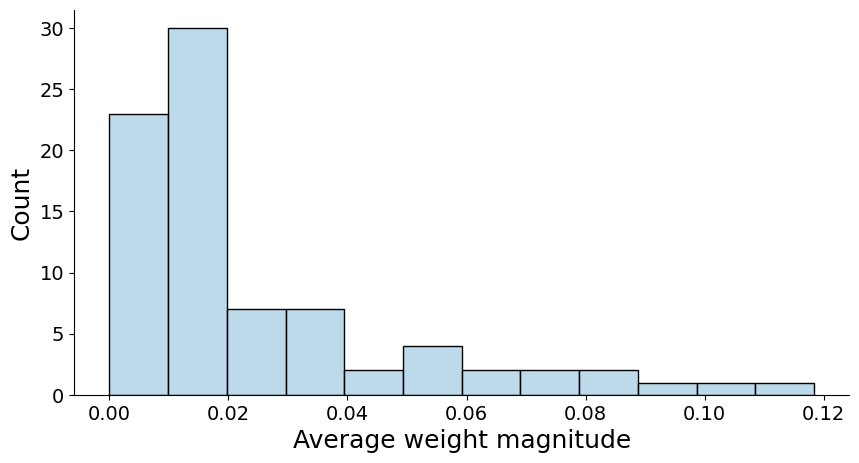

In [69]:
# Distribution of weights
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.histplot(ax=ax, x='weight', data=df_lasso)
sns.despine(top=True, right=True)
plt.xlabel('Average weight magnitude', size=18)
plt.ylabel('Count', size=18)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)

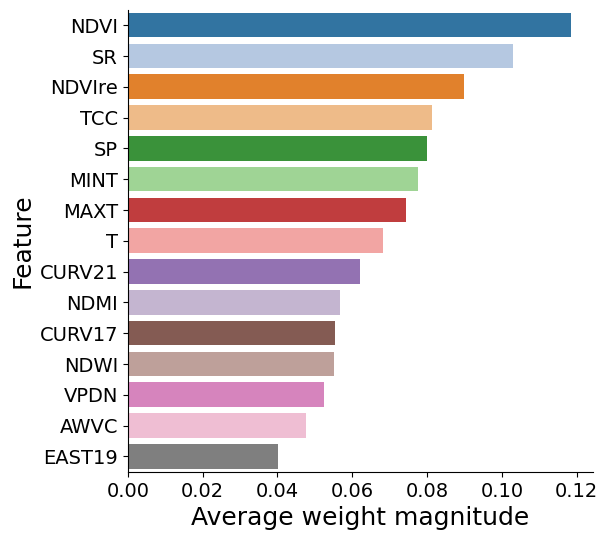

In [11]:
# Select most important features and plot

# Using cutoff at 0.04
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.barplot(ax=ax, x='weight', y='feature', data=df_lasso[df_lasso.weight>0.04], orient='h', palette= sns.color_palette('tab20'))
sns.despine(top=True, right=True)
plt.xlabel('Average weight magnitude', size=18)
plt.ylabel('Feature', size=18)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)

## Recursive removal

In [4]:
top_feats = np.arange(15,0,-1)

In [5]:
val_loss = [0.0236,0.0283,0.0277,0.0277,0.0258,0.0258,0.0261,0.0264,0.0297,0.0272,0.0272,0.0249,0.0249,0.0559,0.0559]
test_loss = [0.0371,0.0409, 0.0465,0.0465,0.0386,0.0386,0.0374,0.0402,0.0454,0.0388,0.0388,0.0493,0.0493,0.0416,0.0416]

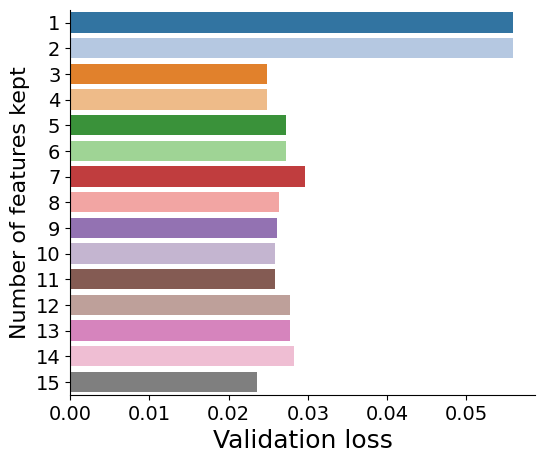

In [6]:
# Plot losses 
fig, ax = plt.subplots(1,1, figsize=(6,5))
sns.barplot(ax=ax, x=val_loss, y=top_feats, orient='h', palette= sns.color_palette('tab20'))
sns.despine(top=True, right=True)
plt.xlabel('Validation loss', size=18)
plt.ylabel('Number of features kept', size=16)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)

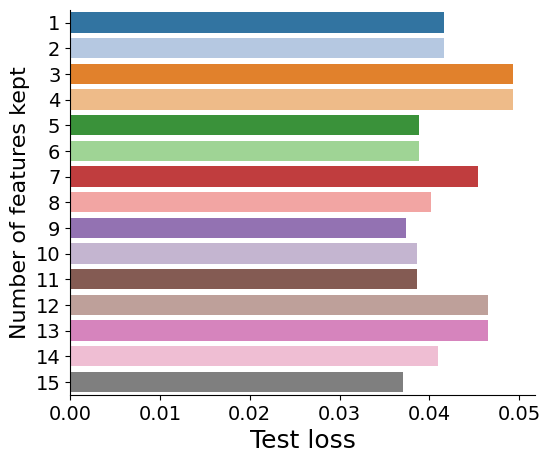

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
sns.barplot(ax=ax, x=test_loss, y=top_feats, orient='h', palette= sns.color_palette('tab20'))
sns.despine(top=True, right=True)
plt.xlabel('Test loss', size=18)
plt.ylabel('Number of features kept', size=16)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)

In [9]:
# Plot importances

val_loss = [0.0283,0.0277,0.0277,0.0258,0.0258,0.0261,0.0264,0.0297,0.0272,0.0272,0.0249,0.0249,0.0559,0.0559]
val_imp = [x-0.0236 for x in val_loss]
test_loss = [0.0409, 0.0465,0.0465,0.0386,0.0386,0.0374,0.0402,0.0454,0.0388,0.0388,0.0493,0.0493,0.0416,0.0416]
test_imp = [x-0.0371 for x in test_loss]

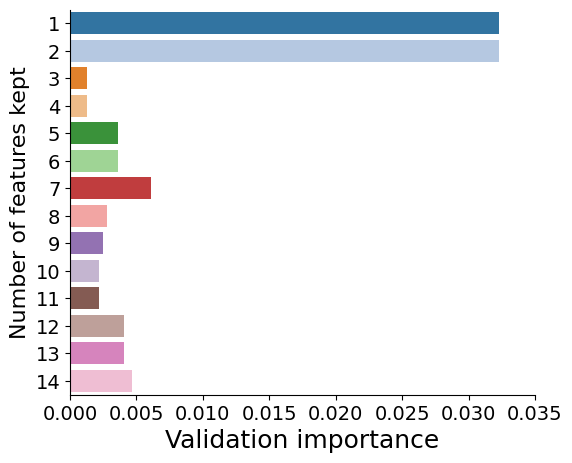

In [16]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
sns.barplot(ax=ax, x=val_imp, y=np.arange(14,0,-1), orient='h', palette= sns.color_palette('tab20'))
sns.despine(top=True, right=True)
plt.xlabel('Validation importance', size=18)
plt.ylabel('Number of features kept', size=16)
# We change the fontsize of minor ticks label 
plt.xlim(0,0.035)
ax.tick_params(axis='both', which='major', labelsize=14)

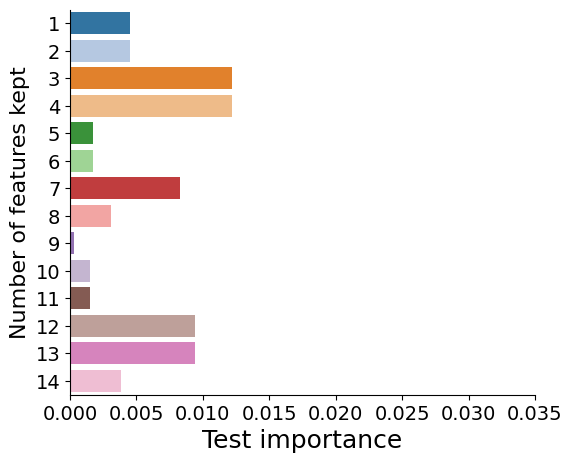

In [17]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
sns.barplot(ax=ax, x=test_imp, y=np.arange(14,0,-1), orient='h', palette= sns.color_palette('tab20'))
sns.despine(top=True, right=True)
plt.xlabel('Test importance', size=18)
plt.ylabel('Number of features kept', size=16)
plt.xlim(0,0.035)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)

## Captum

In [ ]:
from captum.attr import LayerIntegratedGradients, IntegratedGradients
from captum.attr import visualization as viz

In [ ]:
target = 42.0   # target value for regression model

# Define a baseline input sequence
baseline_data = th.zeros_like(x)

# Choose an attribution method to use. In this example, we will use the Layer Integrated Gradients method.
lig = LayerIntegratedGradients(model, model.lstm_cell)

# Call the attribution method on your model and input data to compute the SHAP values.
shap_values, _ = lig.attribute(X_tr, baseline_data, target=target, return_convergence_delta=False)

# Visualize the SHAP values as an image using the Captum visualization module.
viz.visualize_image_attr(shap_values[0], X_tr[0], method='heat_map', sign='all')

### Simpler model

In [ ]:
import torch
import torch.nn as nn

class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(SimpleLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (h, c) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

model = SimpleLSTM(input_dim=10, hidden_dim=32, num_layers=2, output_dim=1)

In [ ]:
x = torch.randn(1, 20, 10)

target = 42.0   # target value for regression model

# Define a baseline input sequence
baseline_data = th.zeros_like(x)

# Choose an attribution method to use. In this example, we will use the Layer Integrated Gradients method.
lig = LayerIntegratedGradients(model, model.lstm)

# Call the attribution method on your model and input data to compute the SHAP values.
shap_values, _ = lig.attribute(x, baseline_data, target=target, return_convergence_delta=False)

# Visualize the SHAP values as an image using the Captum visualization module.
viz.visualize_image_attr(shap_values[0], x[0], method='heat_map', sign='all')

## SHAP

### Keras

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

def LSTM_oneshot(input_dim, hidden_dim, num_layers, output_dim, batch_size):
    # Define the input layer
    input_layer = Input(shape=(None, input_dim), batch_size=batch_size)

    # Define the LSTM layer
    lstm_layer = LSTM(hidden_dim, return_sequences=True, return_state=True, batch_size=batch_size)
    lstm_output, _, _ = lstm_layer(input_layer)

    # Define the output layer (same dim as input)
    output_layer = Dense(output_dim)
    output = output_layer(lstm_output)

    # Create the Keras model
    model = Model(inputs=input_layer, outputs=output)

    return model

### PyTorch

In [ ]:
X_sub = X_tr[0,:,:].unsqueeze(0)

In [ ]:
# define the explainer using your PyTorch model
explainer = shap.DeepExplainer(model, X_tr)

In [ ]:
# calculate the SHAP values for your data
shap_values = explainer.shap_values(X_sub)

In [ ]:
explainer = shap.Explainer(model, X_tr)

# compute SHAP values
shap_values = explainer(X_sub)

In [ ]:
import torch
import shap

# Define your PyTorch LSTM model
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Create an instance of your LSTM model
model = LSTMModel(input_size=10, hidden_size=20, num_layers=2, output_size=1)

# Create a PyTorch tensor for the input data
x = torch.randn(1, 20, 10)

# Create an instance of the SHAP DeepExplainer for your PyTorch LSTM model
explainer = shap.DeepExplainer(model, data=x)

# Compute the SHAP values for the input data
shap_values = explainer.shap_values(x)

In [ ]:
class LSTMWrapper(nn.Module):
    def __init__(self, lstm_model):
        super(LSTMWrapper, self).__init__()
        self.lstm_model = lstm_model
        
    def forward(self, x):
        # Initialize the hidden state and cell state with zeros
        h0 = th.zeros(self.lstm_model.num_layers, x.size(0), self.lstm_model.hidden_size)
        c0 = th.zeros(self.lstm_model.num_layers, x.size(0), self.lstm_model.hidden_size)
        
        # Forward pass through LSTM layer
        lstm_out, self.hidden = self.lstm_model.lstm(x, (h0, c0))
        # process the input sequence and obtain the initial hidden state and cell state. 
        # These hidden states and cell states are then used as the initial states 
        # for the subsequent time steps in the for loop.
        
        # Get the output of the LSTM cell at each timestep
        lstm_outputs = []
        for i in range(lstm_out.size(1)):
            lstm_outputs.append(lstm_out[:, i, :])
        lstm_outputs = th.stack(lstm_outputs, dim=1)

        # Pass the LSTM outputs through the output layer
        out = self.lstm_model.fc(lstm_outputs)

        return out

In [ ]:
model = LSTMModel(input_size=10, hidden_size=20, num_layers=2, output_size=1)
model_wrapper = LSTMWrapper(model)
explainer = shap.DeepExplainer(model_wrapper, data=x)

In [ ]:
# Compute the SHAP values for the input data
shap_values = explainer.shap_values(x)

# Timeshap

In [ ]:
import timeshap

In [ ]:
# Model entry point

from timeshap.wrappers import TorchModelWrapper
model_wrapped = TorchModelWrapper(model)
f_hs = lambda x, y=None: model_wrapped.predict_last_hs(x, y)

In [ ]:
model_features = ['NDVI', 'SR', 'T', 'TP', 'DEM']

In [ ]:
X = np.reshape(X_tr.numpy(), (batch_size_tr*n_timesteps_in, (len(feature_set)-len(remove_bands))))
df = pd.DataFrame(X, columns=model_features, index=np.arange(0,X.shape[0],1).tolist())

In [ ]:
df["all_id"] = np.arange(0,X.shape[0],1).tolist()
sequence_id_feat = "all_id"

In [ ]:
# Baseline event

from timeshap.utils import calc_avg_event
average_event = calc_avg_event(df, numerical_feats=model_features, categorical_feats=[])

In [ ]:
# Baseline sequence

from timeshap.utils import calc_avg_sequence
average_sequence = calc_avg_sequence(df, numerical_feats=model_features, categorical_feats=[],model_features=model_features, entity_col=sequence_id_feat)

In [ ]:
# Average score over baseline

from timeshap.utils import get_avg_score_with_avg_event
avg_score_over_len = get_avg_score_with_avg_event(f_hs, average_event, top=480)

In [ ]:
from timeshap.explainer import global_report 

plot_feats = {
    'p_avg_rss12_normalized': "Mean Chest <-> Right Ankle",
    'p_var_rss12_normalized': "STD Chest <-> Right Ankle",
    'p_avg_rss13_normalized': "Mean Chest <-> Left Ankle",
    'p_var_rss13_normalized': "STD Chest <-> Left Ankle",
    'p_avg_rss23_normalized': "Mean Right Ankle <-> Left Ankle",
    'p_var_rss23_normalized': "STD Right Ankle <-> Left Ankle",
}
plot_feats=None
time_feat = 'all_id'

pos_dataset = df #d_test_normalized[d_test_normalized['label'] == 1]
schema = list(pos_dataset.columns)
pruning_dict = {'tol': [0.05, 0.075], 'path': 'prun_all.csv'}
event_dict = {'path': 'event_all.csv', 'rs': 42, 'nsamples': 32000}
feature_dict = {'path': 'feature_all.csv', 'rs': 42, 'nsamples': 32000, 'feature_names': model_features, 'plot_features': plot_feats}
prun_stats, global_plot = global_report(f_hs, pos_dataset, pruning_dict, event_dict, feature_dict, average_event, model_features, schema, sequence_id_feat, time_feat)
prun_stats

# Drop group feature importance

In [6]:
import seaborn as sns

In [7]:
groups = ["Spectral", "Climate", "Topography", "Soil", "Vegetation"]
val_loss = [0.0221, 0.0561, 0.0225, 0.0198, 0.0238]
test_loss = [0.0394, 0.0413, 0.0355, 0.0349, 0.0387]
val_imp = [x-0.0251 for x in val_loss]
test_imp = [x-0.0366 for x in test_loss]

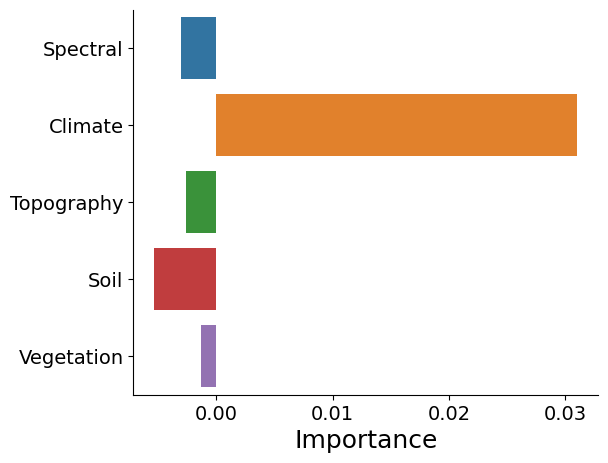

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
sns.barplot(ax=ax, x=val_imp, y=groups, orient='h')
sns.despine(top=True, right=True)
plt.xlabel('Importance', size=18)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)

(-0.003, 0.03)

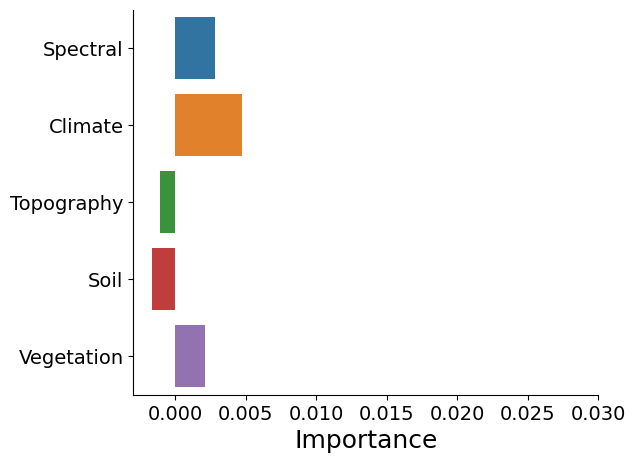

In [12]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
sns.barplot(ax=ax, x=test_imp, y=groups, orient='h')
sns.despine(top=True, right=True)
plt.xlabel('Importance', size=18)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
plt.xlim(-0.003,0.03)